In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!ls /content/gdrive/'MyDrive'/'Colab Notebooks'/ -la
!cp /content/gdrive/'MyDrive'/'Colab Notebooks'/archive.zip .

total 1440261
-rw------- 1 root root  363152213 Dec  7 02:13 archive.zip
-rw------- 1 root root 1111530564 Dec  8 07:20 images.tar.gz
-rw------- 1 root root     143394 Dec 15 08:46 Untitled0.ipynb


In [7]:
!unzip archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating

In [8]:
!nvidia-smi

Tue Dec 22 00:26:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
from scipy import signal as sg
import itertools
import numpy as np
import cv2
import os

# --- laws texture 계산 함수 ---
def laws_texture(gray_image):
    (rows, cols) = gray_image.shape[:2]
    smooth_kernel = (1/25)*np.ones((5,5)) #smoothing 하기 위한 filter
    gray_smooth = sg.convolve(gray_image, smooth_kernel, "same") #흑백이미지 smoothing convolution
    gray_processed = np.abs(gray_image - gray_smooth) #원본-smoothing된 이미지
    
    filter_vectors = np.array([[1, 4, 6, 4, 1],[-1, -2, 0, 2, 1], [-1, 0, 2, 0, 1], [1, -4, 6, -4, 1]]) #L5, E5, S5, R5
    
    filters = []
    for i in range(4):
        for j in range(4):
            #총 4*4 = 16개의 filter들을 5*1행렬 1*5행렬을 행렬 곱셈으로 구함
            filters.append(np.matmul(filter_vectors[i][:].reshape(5,1),filter_vectors[j][:].reshape(1,5)))  
            
    conv_maps = np.zeros((rows, cols, 16)) #convolution 결과를 저장할 conv_maps 선언
    for i in range(len(filters)):
        conv_maps[:, :, i] = sg.convolve(gray_processed, filters[i], 'same') #전처리된 이미지에 16개 필터를 적용시킴
    
    #10개의 texture map 게산(순서는 MIT Media Lab VisTex Database의 Natural textures 표 기준)
    texture_maps = list()
    texture_maps.append((conv_maps[:, :, 5])) #E5E5
    texture_maps.append((conv_maps[:, :, 10])) #S5S5
    texture_maps.append((conv_maps[:, :, 15])) #R5R5
    texture_maps.append((conv_maps[:, :, 1]+conv_maps[:, :, 4])//2) #L5E5 / E5L5
    texture_maps.append((conv_maps[:, :, 2]+conv_maps[:, :, 8])//2) #L5S5 / S5L5
    texture_maps.append((conv_maps[:, :, 3]+conv_maps[:, :, 12])//2) #L5R5 / R5L5
    texture_maps.append((conv_maps[:, :, 6]+conv_maps[:, :, 9])//2) #E5S5 / S5E5
    texture_maps.append((conv_maps[:, :, 7]+conv_maps[:, :, 13])//2) #E5R5 / R5E5
    texture_maps.append((conv_maps[:, :, 11]+conv_maps[:, :, 14])//2) #S5R5 / R5S5
   
    texture_maps.append((conv_maps[:, :, 0])) #L5L5 (norm TEM)
    
    # Law's texture energy
    TEM = list()
    for i in range(len(texture_maps)-1):
        TEM.append(np.abs(texture_maps[i]).sum()/np.abs(texture_maps[9]).sum())
    
    return TEM



# --- Train, Test 이미지 패치 추출 ---
train_dir = './seg_train/seg_train' #train data path
test_dir = './seg_test/seg_test' #test data path
classes = ['buildings','forest','mountain','sea'] #class 이름 배열

# --- Train 이미지 패치 추출 ---
X_train = []
Y_train = []

PATCH_SIZE = 30 #이미지 패치 사이즈 30*30

np.random.seed(1234)
for idx, texture_name in enumerate(classes): #각 클래스 개수 4개까지
    image_dir = os.path.join(train_dir, texture_name) #train data 중 각 class에 있는 경로 중
    for image_name in os.listdir(image_dir): #class data 중 이미지가 있는 경로에 접근
        image = cv2.imread(os.path.join(image_dir, image_name)) #이미지 읽고
        image_s = cv2.resize(image, (100,100), interpolation = cv2.INTER_LINEAR) #100*100으로 resize
        
        for _ in range(10): #총 4*n개의 이미지를 각10개로 나누어 crop함 = 총 40*n개
            h = np.random.randint(100-PATCH_SIZE) #random하게 height, weight를 지정하여 총 한 이미지당 10개를 자른뒤
            w = np.random.randint(100-PATCH_SIZE)
            
            image_p = image_s[h:h+PATCH_SIZE, w:w+PATCH_SIZE]
            image_p_gray = cv2.cvtColor(image_p, cv2.COLOR_BGR2GRAY) #그 이미지를 흑백으로 변환
            #image_hsv = cv2.cvtColor(image_p, cv2.COLOR_BGR2HSV) 이미지를 HSV로도 변환 가능
            
            #GLCM co-occurence 계산(distance = 1, normalize (o), symmetric (x))
            #가로로 co-occurence matrix i,j 관계 계산
            glcm = greycomatrix(image_p_gray, distances=[1], angles=[0],levels=256, symmetric = False, normed = True) 
            #세로로 co-occurence matrix i,j 관계 계산
            #glcm = greycomatrix(image_p_gray, distances=[1], angles=[np.pi/2],levels=256, symmetric = False, normed = True) 
            #대각선(diagonal 방향)으로 co-occurence matrix i,j 관계 계산 
            #glcm = greycomatrix(image_p_gray, distances=[1], angles=[np.pi/4],levels=256, symmetric = False, normed = True) 
            
            X_train.append([greycoprops(glcm, 'dissimilarity')[0, 0], greycoprops(glcm, 'correlation')[0, 0]] + laws_texture(image_p_gray)) 
            #각 label을 추가 buildings : 0, forest : 1, mountain : 2, sea : 3
            Y_train.append(idx)

#numpy array로 선언 뒤 출력            
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print('train data: ', X_train.shape)
print('train label: ', Y_train.shape)
print('\n')

X_test = []
Y_test = []

for idx, texture_name in enumerate(classes): #각 클래스 개수 4개까지
    image_dir = os.path.join(test_dir, texture_name) #train data 중 각 class에 있는 경로 중
    for image_name in os.listdir(image_dir): #class data 중 이미지가 있는 경로에 접근
        image = cv2.imread(os.path.join(image_dir, image_name)) #이미지 읽고
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #그 이미지를 흑백으로 변환
        #crop하는게 아니라 distance를 1로 둠
        glcm = greycomatrix(image_gray, distances=[1], angles=[0],levels=256, symmetric = False, normed = True) 
        
        X_test.append([greycoprops(glcm, 'dissimilarity')[0, 0], greycoprops(glcm, 'correlation')[0, 0]] + laws_texture(image_gray)) 
        Y_test.append(idx) #각 label을 추가 buildings : 0, forest : 1, mountain : 2, sea : 3

X_test = np.array(X_test)
Y_test = np.array(Y_test)
print('test data : ', X_test.shape)
print('test label : ', Y_test.shape)
print('\n')

train data:  (92480, 11)
train label:  (92480,)


test data :  (1946, 11)
test label :  (1946,)




In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchsummary import summary

# --- 데이터셋 클래스 ---
class textureDataset(Dataset): #dataset 클래스
    def __init__(self, features, labels): #initialization
        self.features = features #x, 특징
        self.labels = labels #y, 라벨
        
    def __len__(self): #데이터셋 크기 구하는 함수
        return len(self.labels) 
    
    def __getitem__(self,idx): # idx 번째 샘플을 반환
        if torch.is_tensor(idx): #idx가 pytorch tensor면
            idx= idx.tolist() #idx를 list로 변환
        feature = self.features[idx]
        label = self.labels[idx]
        sample = (feature, label) #idx번째 특징과 라벨을 샘플로 묶어 반환
        return sample
    
# --- 신경망 모델 클래스 ---    
class MLP(nn.Module): #MLP class
    def __init__(self, input_dim, hidden_dim, output_dim): #initalization
        super(MLP, self).__init__() 
        self.fc1 = nn.Linear(input_dim, hidden_dim) #fc1 : input dimmension *hidden dimension
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) #fc2 : hidden dimmension *hidden dimension
        self.fc3 = nn.Linear(hidden_dim, output_dim) #fc3 : hidden dimmension *output dimension
    
    def forward(self, x): #x : input_dim
        out = self.fc1(x) #out : hidden_dim
        out = self.relu(out) #out : hidden_dim
        out = self.fc2(out) #out : hidden_dim
        out = self.relu(out) #out : hidden_dim
        out = self.fc3(out) #out : output_dim
        
        return out

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU : 'cuda', CPU : 'cpu'

batch_size = 10 #배치 사이즈
learning_rate = 0.01 #학습률
n_epoch = 500 #epoch

Train_data = textureDataset(features = X_train, labels = Y_train) #train data 정의
Test_data = textureDataset(features = X_test, labels = Y_test) # test data 정의

Trainloader = DataLoader(Train_data, batch_size = batch_size, shuffle = True) #train data loader 정의
Testloader = DataLoader(Test_data, batch_size = batch_size) #test data loader 정의

net = MLP(11, 8, 4) #MLP 모델 정의 input layer dimension은 11개의 feature로 이루어져있어서 11개, output layer dimension은 네 개의 class를 다루므로 4개
net.to(device) #모델을 device로 보냄
summary(net, (11,), device = 'cuda' if torch.cuda.is_available() else 'cpu') #해당 MLP model layer summary

optimizer = optim.SGD(net.parameters(), lr = learning_rate) #optimizer 정의
criterion = nn.CrossEntropyLoss() #loss 계산식은 multi class이므로 crossentropy

train_losses = [] #학습 loss 저장할 배열
train_accs = [] #학습 accuracy 저장할 배열
test_losses = [] #validation loss 저장할 배열
test_accs = [] #validation accuracy 저장할 배열

# --- 학습 ---
for epoch in range(n_epoch): #각 epoch마다
    train_loss = 0.0 #train_loss 를 0으로 초기화
    evaluation = [] #예측 정확도 저장할 list
    net.train() #모델을 학습 모드로 전환
    for i, data in enumerate(Trainloader, 0): #각 batch마다
        features, labels = data #데이터를 feature,label로 나눔
        labels = labels.long().to(device) #각 label 타입을 long형변환한 뒤 device로 보냄
        features = features.to(device) #feature도 device로 보냄
        optimizer.zero_grad() #optimizer와 gradient를 0으로 초기화
        
        outputs = net(features.to(torch.float)) #특징을 float형으로 변환후 모델에 입력
        
        _, predicted = torch.max(outputs.cpu().data, 1) #출력의 제일 큰 값의 index 반환
        evaluation.append((predicted == labels.cpu()).tolist()) #정답과 비교하여 True, False값을 저장
        loss = criterion(outputs, labels) #output과 label을 비교하여 loss 계산
        loss.backward() #역전파. 기울기 계산
        optimizer.step() #가중치 값 업데이트, 학습 한번 진행
        train_loss += loss.item() #loss를 train_loss에 다 더함
        
    train_loss = train_loss/(i+1) #평균 trian_loss
    evaluation = [item for sublist in evaluation for item in sublist] #[True,false] 값을 list로 저장
    train_acc = sum(evaluation)/len(evaluation) #True인 비율 계산
    
    train_losses.append(train_loss) #해당 epoch의 train_loss 
    train_accs.append(train_acc) #해당 epoch의 train_acc
    
    # --- 테스트 ---
    if (epoch+1) % 1 == 0:
        test_loss = 0.0 #test_loss를 0으로 초기화
        evaluation = []
        net.eval() #모델을 평가 모드로 전환
        for i, data in enumerate(Testloader, 0): #각 batch마다
            features, labels = data #데이터를 feature,label로 나눔
            labels = labels.long().to(device) #각 label 타입을 long형변환한 뒤 device로 보냄
            features = features.to(device) #feature도 device로 보냄
            
        
            outputs = net(features.to(torch.float)) #특징을 float형으로 변환후 모델에 입력
        
            _, predicted = torch.max(outputs.cpu().data, 1) #출력의 제일 큰 값의 index 반환
            evaluation.append((predicted == labels.cpu()).tolist()) #정답과 비교하여 True, False값을 저장
            loss = criterion(outputs, labels) #output과 label을 비교하여 loss 계산
            test_loss += loss.item() #loss를 test_loss에 다 더함

    test_loss = test_loss/(i+1) #평균 test_loss
    evaluation = [item for sublist in evaluation for item in sublist] #[True, False] 값을 list로 저장
    test_acc = sum(evaluation)/len(evaluation) #True인 비율 계산
    
    test_losses.append(test_loss) #해당 epoch의 test_loss
    test_accs.append(test_acc) #해당 epoch의 test_acc
    
    print('[%d, %3d]\tloss: %.4f\tAccuracy : %.4f\t\tval-loss : %.4f\tval_Accuracy : %.4f' %(epoch+1, n_epoch, train_loss, train_acc, test_loss, test_acc))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              96
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 8]              72
              ReLU-4                    [-1, 8]               0
            Linear-5                    [-1, 4]              36
Total params: 204
Trainable params: 204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[1, 500]	loss: 1.1605	Accuracy : 0.4276		val-loss : 1.0597	val_Accuracy : 0.4918
[2, 500]	loss: 1.1343	Accuracy : 0.4400		val-loss : 1.0471	val_Accuracy : 0.5180
[3, 500]	loss: 1.1289	Accuracy : 0.4421		val-loss : 1.0484	val_Accuracy : 0.4810

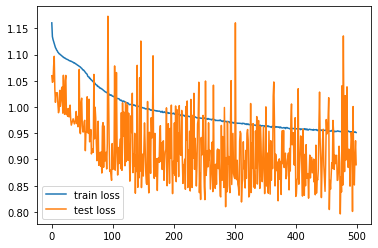

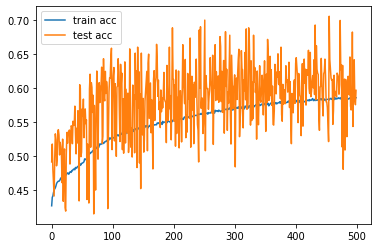

In [12]:
# --- train/test loss/acc visualization ---
plt.plot(range(len(train_losses)), train_losses, label = 'train loss')
plt.plot(range(len(test_losses)), test_losses, label = 'test loss')
plt.legend()
plt.show()
plt.plot(range(len(train_accs)), train_accs, label = 'train acc')
plt.plot(range(len(test_accs)), test_accs, label = 'test acc')
plt.legend()
plt.show()